### Conducting Social Network Analysis (SNA) & Community Detection in Snowball Sample Groups

Social Network Analysis (SNA) consists of methods for identifying the structure -- and strength -- of relationships between nodes, i.e. Facebook pages or groups, based on interactions. When it comes to Facebook, it is particularly useful for identifying:

* The degree to which Facebook pages are amplifying content from identical or common sources (news sources, other Facebook pages, each other, etc.) in a coordinated manner.

* The extent to which Facebook groups are targeted with content from identical or common sources (news sources, Facebook pages, individual users, etc.).

Groups that are frequently targeted with common information sources may constitute 'echo-chambers' susceptible to partisan narratives -- and disinformation that reinforces those narratives.

In addition, once you have conducted an SNA, you can use Community Detection algorithms to partition networks into more discrete clusters. For example, one cluster of nodes may be frequently targeted with information from sources 'A', 'B', and 'C' while another cluster may be smaller and frequently targeted with content from sources 'D' and 'E'. This level of granularity can be helpful for identifying more niche, issue-driven sub-communities. 

In this example, we will examine the extent to which Republican Groups identified via snowball sample may constitute information echo-chambers and whether discrete communities can be partitioned, with a particular focus on identifying a pro-Georgia Republican community for analysis.

**This script assumes you have run scripts from the Sampling Facebook Pages & Groups notebook to collect (up to) the last 10,000 posts from the "Republican Snowball Groups" CrowdTangle list and store those posts in a database. A dataset of 10,000 posts is a relatively small sample. It is preferable to have larger sample, but this dataset should suffice for the purposes of this example.* 


First, we import packages needed for script and add a database connection to retrieve posts we collected and stored from sample groups.

In [260]:
import pandas as pd
from urllib.parse import urlsplit #,urlparse, parse_qs 
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import pyodbc 
from sqlalchemy import create_engine

#database connection:
connection_string = 'your_database_connection_string'
engine = create_engine(connection_string, encoding='utf8')
db = engine.connect()

Then we'll grab the posts from Republican groups sample we collected and stored in our database in the previous notebook.

In [261]:
repgroups_snowball = pd.read_sql_table("republican_groups_snowball_posts", con=db)

We'll create a function called 'prep_sna_group' to pre-process our data for Social Network Analysis. 

This script specifically uses the Facebook assigned 'platformId' of the group as the 'target' and the handle of the 'source' of posted content to the group -- this may be content that was shared from a public Facebook page or  from an inidivual Facebook account, i.e. a private Facebook user. By extracting 'sources' and 'targets', we will be able to map the degree to which groups are targeted with common sources of information.

NB: The source handle - which is either a text string from the URL of a public Facebook page (e.g. joeSmith) or a numeric identifier (e.g. 987654) of a Facebook user. It is contained in the link variable and must be parsed using url splitting techniques.

In [262]:
def prep_sna_group(data):
    #subset just key columns
    data_sub = data[['name', 'url', 'platformId', 'subscriberCount', 'link']]
    #remove rows where there is no link  value
    data_sub = data_sub[pd.notnull(data_sub['link'])]
    #remove rows where link contains 'photo.php' - there is no user id handle in those links
    data_sub = data_sub[~data_sub['link'].str.contains(r"photo.php")]
    #find + remove '/groups' in link
    data_sub['link'] = data_sub['link'].replace(to_replace=r"/groups", value='', regex=True)
    #find + remove '/photos' in link
    data_sub['link'] = data_sub['link'].replace(to_replace=r"/photos", value='', regex=True)
    #find + remove "?" in link 
    data_sub['link'] = data_sub['link'].replace(to_replace=r"\?", value='', regex=True)
    #find + remove "fbid=" in link 
    data_sub['link'] = data_sub['link'].replace(to_replace=r"fbid=", value='', regex=True)
    #find + remove '&" + everything afterwards in link 
    data_sub['link'] = data_sub['link'].replace(to_replace=r"\&.*", value='/', regex=True)
    #parse cleaned up link url to separate components into different columns
    data_sub['protocol2'], data_sub['domain2'], data_sub['path2'], data_sub['query2'], data_sub['fragment2'] = zip(*[urlsplit(i) for i in data_sub['link']])
    #keep only rows where domain is facebook.com
    data_sub = data_sub[data_sub['domain2'] == 'www.facebook.com']
    #change Facebook Id value to 'target' (this is id of the group where post was shared)
    data_sub['target'] = data_sub['platformId']
    #change path2 value to 'source' (this is the id of the user that targeted the group)
    data_sub['source'] = data_sub['path2'].str.extract(r'/\s*([^\/]*)\s*\/', expand=False)
    #add column 'group' that is the same as 'Group Name'. in some functions, space btwn Group and Name causes probs
    data_sub['group'] = data_sub['name']
    #remove any rows where 'source' is null -- probably caused by  find + remove error...to be examined 
    data_sub = data_sub[pd.notnull(data_sub['source'])].reset_index(drop=True)
    #return the final cleaned table
    return data_sub

We pass the posts data to our prep_sna_group function to obtain the 'targets' (groups) and 'sources'

In [263]:
repgroups_pairs = prep_sna_group(repgroups_snowball) 

We subset the data to get just three columns of interest: name, target and source. 
The name is the group (name) which corresponds to the target, which is merely a numerical identifier. Extracting the name of the group is useful for adding labels to our SNA graph. 
As mentioned previously, the source is the handle (text string or numeric identifier) of the original content provider for the post. 
Also, to make sure the data is clean for social network analysis purposes, remove any rows where the source is null. 

In [264]:
repgroups_pairs = repgroups_pairs[['name','target','source']]
repgroups_pairs = repgroups_pairs[pd.notnull(repgroups_pairs['source'])]

We'll delete any rows where the source and the target are identical. 
NB: this is not relevant when conducting SNAs on groups data since a group cannot act as a 'user' (a group is merely a space for users to post), but it is relevant for pages, i.e. when a user re-shares an earlier post or photo from his / her own timeline. Thus we leave it here for demonstration purposes to show how it can be done. 

In [265]:
repgroups_index = repgroups_pairs[repgroups_pairs['target'] == repgroups_pairs['source']].index
repgroups_pairs.drop(repgroups_index, inplace=True)

One measure of strength of relationships between sources and targets is the frequency with which a given source posts to a target -- this is the 'weight' of the relationship. We calculate it here as a last pre-processing step before passing the data to a graph object for visualization purposes.  

In [306]:
repgroups_weight = pd.DataFrame(repgroups_pairs.groupby(['name', 'target', 'source']).size().reset_index())
repgroups_weight = repgroups_weight.rename(columns={0: 'weight'}).reset_index(drop=True)
repgroups_weight = repgroups_weight.sort_values(by='weight', ascending=False).reset_index(drop=True)

We can take a peek at the most prominent information sources posted across all group posts in our snowball sample. This provides us a sense of which sources are 

In [400]:
repgroups_weight.groupby('source').sum().sort_values(by='weight', ascending=False).head(20)

,weight
source,
DonaldTrump,85
events,69
153080620724,57
rightsidebroadcasting,24
141991342558232,23
Breitbart,20
calltoactivism,19
104732037951201,19
perduesenate,16


In this sample, it appears that the Facebook page of Donald Trump is the most common source of content across our groups. Other sources such as the Facebook pages of Breitbart, Fox News and candidates David Perdue and Kelly Loeffler feature prominently. Other notable sources of content include the Facebook pages of newly-elected Congresswoman Marjorie Taylor Greene and a page called Do Not Concede 2020: https://www.facebook.com/donotconcede2020/.

To facilitate graph visualization, we'll remove any sources that appear only once across the entire dataset, i.e. content has been posted from the source just one time across all groups. 
We'll also remove any 'weak' relationships, i.e. where a content from a given source has only been posted one time to one group. 

In [401]:
repgroups_weight_net = repgroups_weight[repgroups_weight['source'].isin(repgroups_weight['source'].value_counts()[repgroups_weight['source'].value_counts() > 1].index)]
repgroups_weight_net = repgroups_weight[repgroups_weight['weight'] > 1]

To make the graph more readable, we'll extract the group names and source handles and store them in Python dictionary objects. We'll use the groups dictionary to display group names on our graph (we likely won't use the user handles since there are likely too many to be display legibly on the graph).

In [366]:
groups = list(repgroups_weight_net['name'].unique())
shared = list(repgroups_weight_net['source'].unique())
node_labels = dict(zip(groups, groups))
shared_labels = dict(zip(shared, shared))

Now we'll convert our data - weighted by relationship between target and source - into graph object named 'G'. 

We'll use a "spring_layout" graph visualization to help make the visualization as readable as possible. 

NB: Rendering SNA graphs is part art and part science: there are many layout options that can be tested to produce readable graph visualizations https://networkx.org/documentation/stable//reference/drawing.html. In this case, we use the "spring_layout" and the 'k' value controls the distance (spacing) between the nodes in the social network graph and varies between 0 and 1. G.order() returns the number of nodes in the graph. This variable can be tinkered with for node spacing for aesthetic purposes - examples of other layouts are included here but commented out (remove the # before the layout object to try different visualization options). 

In [441]:
G = nx.from_pandas_edgelist(repgroups_weight_net, source='source', target='name', edge_attr=True)
layout = nx.spring_layout(G, k=10/G.order())
#layout = nx.kamada_kawai_layout(G)
#layout = nx.fruchterman_reingold_layout(G, k=1/G.order())
#layout = nx.spiral_layout(G)

We'll get the degree centrality of groups in the network. Degree centrality is one measure of importance of nodes in a social network. In this case, a group that is targeted with many sources of information would have a high degree of centrality (in other words, a highly active group that is highly targeted). Degree centrality here will be illustrated by the size and color of the target group nodes.  
<br />
NB: Degree centrality is not a flawless measure of "importance" of a group in a networks. Other measures could reasonably be used -- such as the number of members in a group. However a group with many members may not be that important if it is not very active.

In [442]:
dc = nx.degree_centrality(G)
hi_degree_targets = [k for k, v in dc.items() if k in groups and v > 0.03]
node_labels_top = dict(zip(hi_degree_targets, hi_degree_targets))
#color based on degree size leveraging nx spectrum
node_color = [20000.0 * G.degree(v) for v in G]
#same with size
node_size =  [v * 10000 for v in dc.values()]

Now we'll visualize the SNA graph. The graph illustrates the extent to which groups are targeted with common sources of information. Specifically, the closer the groups are clustered together on the graph, the more they are targeted with common information sources. The futher apart, the more distinct the content sources. 

NB: NetworkX is not optimal for graph visualization (i.e. the graphs are not always pretty and readable) however it is useful for exploratory purposes. If you are interested in creating beautiful and professional-looking SNA graphs, you can export your network 'G' to a .gexf file that can be uploaded to the open-source graph visualization platform Gephi with the following code: nx.write_gexf(G, "repgroups_weight_net.gexf")

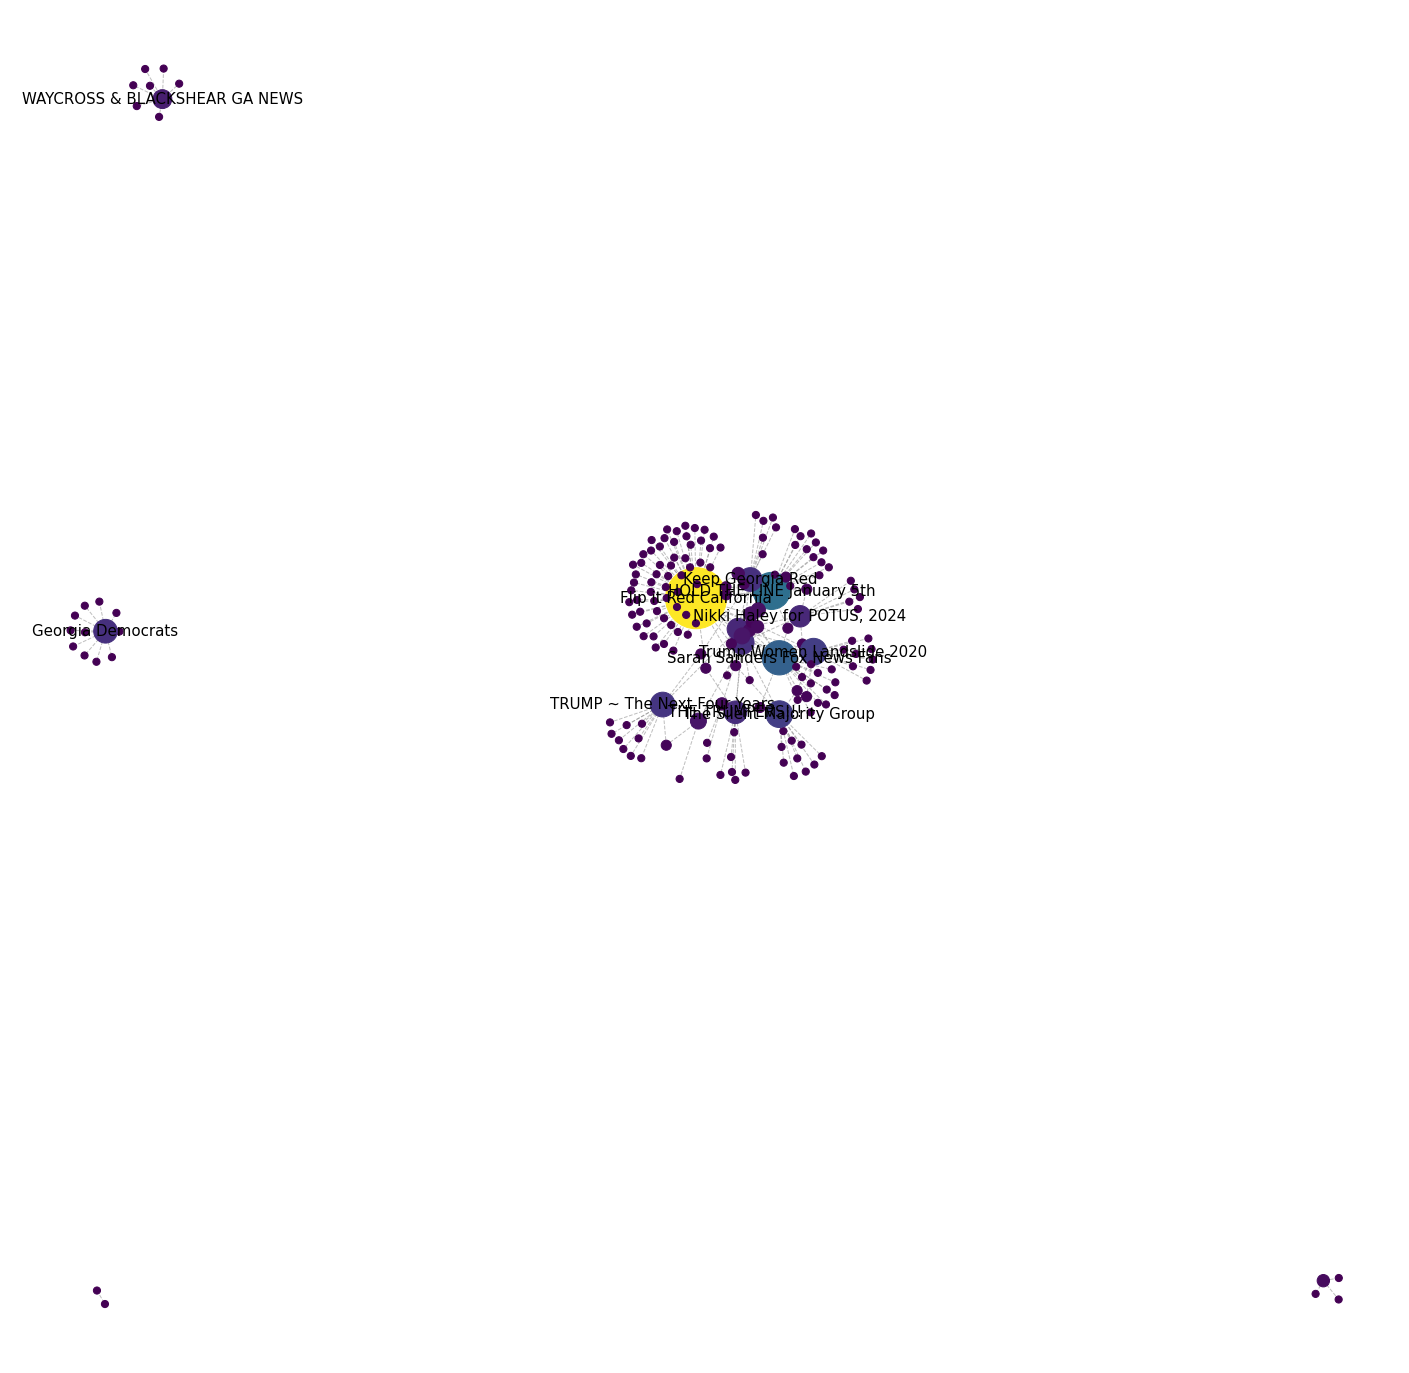

In [443]:
#set plotting area 
fig = plt.figure(figsize=(25,25))
#plot nodes & edges
nx.draw_networkx_nodes(G, layout, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, layout, width=1, alpha=0.5, edge_color='gray', style='dashed')
#add labels for just the high degree targets
nx.draw_networkx_labels(G, layout, labels=node_labels_top, font_size=15)
plt.axis('off')
plt.show()

At a glance, the social network graph above clearly shows one very large network cluster of groups, several of which have "Trump" in the group name. A smaller cluster clearly separate from the large cluster is anchored by a group named "Georgia Democrats." And a handful of small clusters with no significant appear to be arrayed elsewhere on the graph, including one in the top left hand corner.

NB: If you are confused by the presence of "Georgia Democrats": in the snowball sample, content from one of the Republican source pages must have been shared to the Georgia Democrats group, possibly with the intent to discredit, condemn or attack. Consequently, this group show ups in our SNA and, logically, form a noticeably discrete cluster in the graph.

While a social network graph is useful for depicting relationships between groups however we are interested in extracting which groups form clusters and constitute echo-chambers. To do that, we need to use a community detection algorithm to partition the network into discrete and logical communities. 

To facilitate graph visualization, we removed unique sources and 'weak' relationships. For our community detection algorithm, we'll create another graph object that includes all sources - common, unique, strong and weak - and then partition the communities. The results of our community detection algorithm should correspond to what we saw on the graph! 

In [444]:
G = nx.from_pandas_edgelist(repgroups_weight, source='source', target='name', edge_attr=True)
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities_detected = sorted(map(sorted, next_level_communities))

Now that we created our new graph object, we'll see how many discrete, partitioned communities were found with  all targets and sources in those communities.

In [445]:
for idx, i in enumerate(communities_detected):
    print(idx, len(i))

0 2
1 718
2 43
3 20
4 2
5 3
6 2
7 2


Per the community detection algorithm, eight distinct communities were detected, including one large one composed of more than 700 sources and targets -- this is surely the large cluster of groups, some of which have "Trump" in the name, displayed on the graph. Two (much) smaller clusters have 43 and 20 sources and targets, respectively. Presumably, one of these is the cluster that appeared on the graph anchored by "Georgia Democrats". 

Communities numbered 1, 2 and 3 are significant enough that they warrant some data exploration. To extract the names of the target groups in these communities, we'll write a script that converts our communities into dataframes and matcesh the names contained in the groups with the names of groups in our original snowball data  set.  This will give us filtered datasets of posts by communities which we can use for analysis in later scripts. 

In [434]:
def community_groups(com_id):
    temp = pd.DataFrame(communities_detected[com_id], columns=['name'])
    temp_posts = repgroups_snowball.loc[repgroups_snowball['name'].isin(temp['name'])]
    temp_groups = temp_posts.groupby(['name']).size().to_frame().reset_index().sort_values(by=0, ascending=False)
    temp_groups = temp_groups.rename(columns={0: 'posts'}).reset_index(drop=True)
    return temp_groups

Now let's look at the groups found in community 1:

In [436]:
community_groups(1)

,name,posts
0,HOLD THE LINE January 5th,1823
1,Flip it Red California,1785
2,TRUMP ~ The Next Four Years,740
3,The Silent Majority Group,702
4,THE TRUMPERS!!!,681
5,Trump Women Landslide 2020,615
6,Keep Georgia Red,536
7,Grassroots For Doug Collins,486
8,"Nikki Haley for POTUS, 2024",379
9,Sarah Sanders Fox News Fans,216


Just as we suspected, this community corresponds to the large cluster we saw on the graph. The cluster is a mix of pro-Trump and pro-Georgia Republican groups (and some other pro-Republican groups). 

Activity in this community is obviously what we want to further analyze. We'll revisit this community a little bit, but let's take a look at community 2.

In [437]:
community_groups(2)

,name,posts
0,Georgia Democrats,535


The second community is clearly the small cluster of pro-Democratic groups anchored by the group 'Georgia Democrats' on the graph. It is an outlier and can be ignored for further analysis. 

Now let's take a look at community 3, just to see what it is. 

In [446]:
community_groups(3)

,name,posts
0,WAYCROSS & BLACKSHEAR GA NEWS,95


The third community is clearly another outlier. Based on the name, there is no indication that this a pro-Republican group. It appears to be a general news group for a couple of Georgia towns. Content from one of the seed pages must have been shared to this group at some point and thus it was caught in the snowball! We can take a look at some of the messages in this group to get a better sense of what is discussed in that group.

In [459]:
repgroups_snowball.loc[repgroups_snowball['name'] == 'WAYCROSS & BLACKSHEAR GA NEWS']['message'].head(10)

180                                                  None
317     Thank you to the Waycross/ware County Fire Dep...
318     Please Report Any Disrespectful Comments Direc...
319     My sister just called me and said someone’s wh...
481                                                  None
642     "...as we near the end of a challenging year, ...
974                                                  None
975     So the Sheriff seems adamant in asking $45 per...
976     SINCE THERE HAVE BEEN MANY RULE VIOLATIONS, HE...
1358                                                 None
Name: message, dtype: object

(at cursory glance, the messages in this group do not appear to be overtly political).

Let's revisit the first community and do some manual culling of this cluster to extract overtly pro-Georgia Republican groups. 

While the mix of groups in the first community is logical due to overlap in information sources, we want to isolate pro-Georgia Republican groups to the extent possible. We naturally assume that groups with Georgia-specific references in their names are likely more engaged in political discussions related to the January runoff election. 

We'll create a list of reference words to filter the groups in community one to extract as many pro-Georgia Republican groups as possible. 

In [481]:
community_one = community_groups(1)
ga_keywords = ['Georgia', 'January', 'Doug Collins', 'GA', 'Barrow', 'Cobb', 'Hart']
georgia_republican_groups = community_one[community_one['name'].str.contains('|'.join(ga_keywords))]
georgia_republican_groups

,name,posts
0,HOLD THE LINE January 5th,1823
6,Keep Georgia Red,536
7,Grassroots For Doug Collins,486
10,We the People of Georgia Group,168
12,Southest GA Conservatives,110
13,"Citizens of Berrien County, Georgia",99
16,Georgians for Kelly Loeffler,80
17,Northwest GA Civil Defense League,72
18,SOUTHEAST GA BULLETIN BOARD,67
22,Georgia Republicans United,45


This leaves us with a community of 16 pro-Georgia Republican groups within which we can analyze behavior and activity (extracting topics, analyzing sentiment, identifying news sources, etc.)

We'll grab the group urls for these 16 pro-Georgia Republican groups from our snowball sample, prepare these 16 groups for a batch upload to CrowdTangle, and export a CSV file to be uploaded (be sure to create a list of groups named 'GA Republican Groups' before uploading the CSV file!).

In [487]:
ga_republican_groups = repgroups_snowball[repgroups_snowball['name'].isin(georgia_republican_groups['name'])]

def prep_batch_from_posts(data, atype='pages', minsize=0, listname='null'):
    df = data
    df = df.groupby(['name', 'url', 'accountType']).size().to_frame().reset_index().sort_values(by=0, ascending=False)
    if atype == 'pages':
        df1 = df.loc[((df['accountType'] == 'facebook_page') & (df[0] > minsize))]
    else: #need to fix the else to set to 'groups' as an option -- not a big deal right now
        df1 = df.loc[((df['accountType'] == 'facebook_group') & (df[0] > minsize))]
    df1['List'] = listname
    df1 = df1.rename(columns={"url": "Page or Account URL"}).reset_index(drop=True)
    return df1[['Page or Account URL', 'List']] 

ga_republican_groups_batch = prep_batch_from_posts(ga_republican_groups, atype='groups', listname='GA Republican Groups')
ga_republican_groups_batch.to_csv("garepgroups.csv", index=False)

In the next notebook, we'll grab posts from these 16 pro-Gerogia Republican groups and analyze the news sources and articles that are being shared in these 16 pro-Georgia Republican groups -- including from sources known to share false and misleading information! 